# Transfer learning and fine-tuning

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## Data preprocessing

### Data path upload

In [104]:
train_dir = os.path.join('D:/Tomato PDD/ICT4SD4/data3/train/')
validation_dir = os.path.join('D:/Tomato PDD/ICT4SD4/data3/val/')

BATCH_SIZE = 64
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2800 files belonging to 7 classes.


In [105]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 700 files belonging to 7 classes.


['Bacterial_spot', 'Black_mold', 'Early_blight', 'Healthy', 'Late_blight', 'Mosaic_virus', 'Septoria_spot']


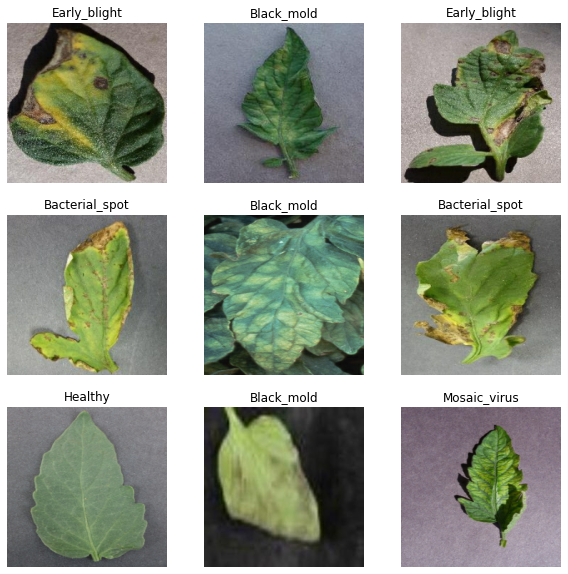

In [106]:
class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [107]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [108]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 9
Number of test batches: 2


### Configure the dataset for performance

In [109]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [110]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

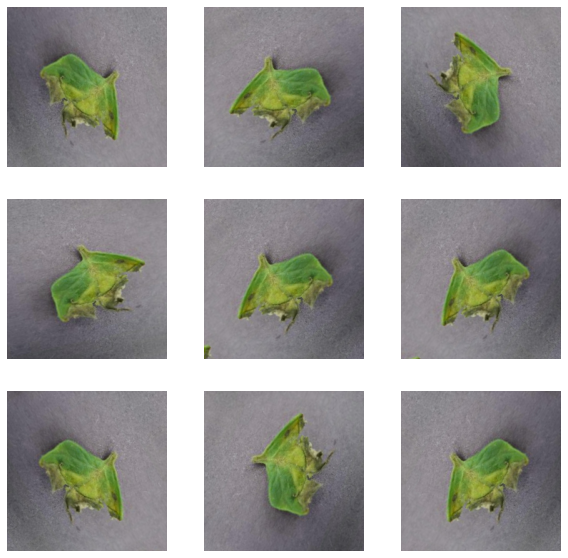

In [111]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In [112]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [113]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

## Create the base model from the pre-trained convnets

In [114]:
# Create the base model from the pre-trained model CNN application
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [115]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1280)


## Feature extraction

### Freeze the convolutional base

In [116]:
base_model.trainable = False

In [117]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

### Add a classification head

In [118]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [119]:
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 7)


In [120]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [121]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

C:\Users\Kartik\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [122]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 8967      
Total params: 4,058,538
Trainable params: 8,967
Non-trainable params: 4,049,571
_____________________________________________

In [123]:
len(model.trainable_variables)

2

### Train the model

In [124]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

9/9 [==============================] - 18s 2s/step - loss: 2.0059 - accuracy: 0.1521


In [125]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.01
initial accuracy: 0.15


In [126]:
from datetime import datetime

start = datetime.now()

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
print(" ")
print(datetime.now()-start)

Epoch 1/10
44/44 [==============================] - 106s 2s/step - loss: 1.9541 - accuracy: 0.1671 - val_loss: 1.8434 - val_accuracy: 0.2692
Epoch 2/10
44/44 [==============================] - 107s 2s/step - loss: 1.8141 - accuracy: 0.2982 - val_loss: 1.7363 - val_accuracy: 0.3654
Epoch 3/10
44/44 [==============================] - 106s 2s/step - loss: 1.7044 - accuracy: 0.3968 - val_loss: 1.6550 - val_accuracy: 0.4476
Epoch 4/10
44/44 [==============================] - 105s 2s/step - loss: 1.6107 - accuracy: 0.4411 - val_loss: 1.5844 - val_accuracy: 0.4913
Epoch 5/10
44/44 [==============================] - 104s 2s/step - loss: 1.5382 - accuracy: 0.5036 - val_loss: 1.5159 - val_accuracy: 0.5105
Epoch 6/10
44/44 [==============================] - 104s 2s/step - loss: 1.4761 - accuracy: 0.5271 - val_loss: 1.4575 - val_accuracy: 0.5507
Epoch 7/10
44/44 [==============================] - 105s 2s/step - loss: 1.4100 - accuracy: 0.5611 - val_loss: 1.4074 - val_accuracy: 0.5664
Epoch 8/10
44

### Learning curves

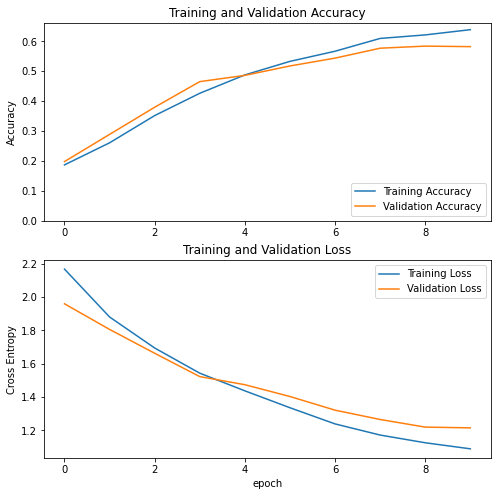

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

### Un-freeze the top layers of the model

In [68]:
base_model.trainable = True

In [69]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


### Compile the model

In [70]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [71]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [72]:
len(model.trainable_variables)

56

In [73]:
from datetime import datetime

start = datetime.now()

total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         callbacks=[cb],
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)
print(" ")
print(datetime.now()-start)

Epoch 10/20
44/44 [==============================] - 78s 2s/step - loss: 0.8780 - accuracy: 0.6971 - val_loss: 0.9276 - val_accuracy: 0.6469
Epoch 11/20
44/44 [==============================] - 77s 2s/step - loss: 0.7104 - accuracy: 0.7518 - val_loss: 0.8739 - val_accuracy: 0.6608
Epoch 12/20
44/44 [==============================] - 81s 2s/step - loss: 0.6240 - accuracy: 0.7814 - val_loss: 0.8074 - val_accuracy: 0.6976
Epoch 13/20
44/44 [==============================] - 81s 2s/step - loss: 0.5482 - accuracy: 0.8046 - val_loss: 0.7810 - val_accuracy: 0.6993
Epoch 14/20
44/44 [==============================] - 81s 2s/step - loss: 0.5029 - accuracy: 0.8261 - val_loss: 0.7096 - val_accuracy: 0.7448
Epoch 15/20
44/44 [==============================] - 83s 2s/step - loss: 0.4601 - accuracy: 0.8407 - val_loss: 0.8207 - val_accuracy: 0.7133
Epoch 16/20
44/44 [==============================] - 79s 2s/step - loss: 0.4244 - accuracy: 0.8514 - val_loss: 0.7632 - val_accuracy: 0.7273
Epoch 17/20
4

In [74]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

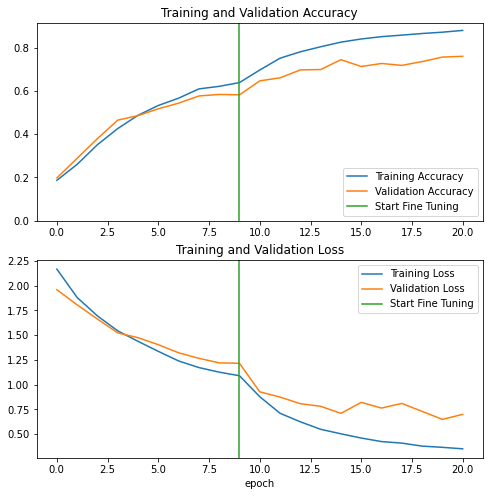

In [75]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, max(plt.ylim())])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [76]:
start = datetime.now()

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print(' ')
print(datetime.now()-start)

2/2 [==============================] - 2s 1s/step - loss: 0.7765 - accuracy: 0.7266
Test accuracy : 0.7265625
 
0:00:02.306455


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
Labels:
 [3 1 3 6 4 2 4 6 1 6 5 6 5 5 4 5 1 4 5 5 2 0 3 1 6 6 6 2 2 2 4 3 0 

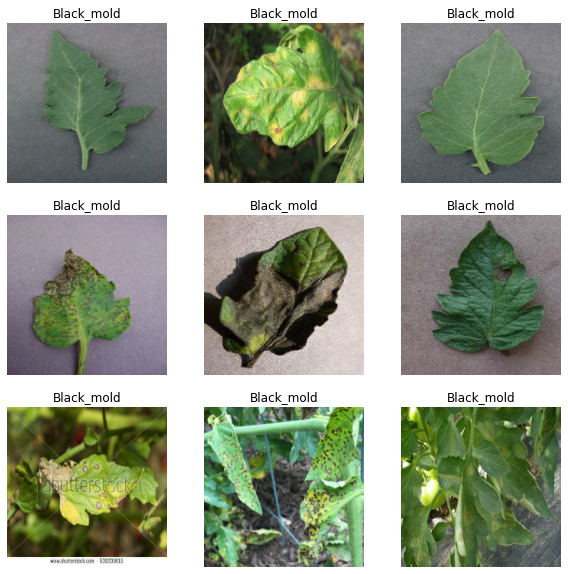

In [77]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Create a Confusion Matrix

In [96]:
predictions = model.predict(x=test_dataset)

In [97]:
for i in predictions:
    print(i)

[0.5576709  0.0167834  0.22485878 0.00416433 0.08374296 0.01944037
 0.09333929]
[3.5304300e-05 1.4502120e-04 3.2136624e-05 9.9872005e-01 4.0563178e-04
 5.7950174e-04 8.2394676e-05]
[5.1436387e-04 3.4275007e-02 5.2677143e-01 4.2462716e-01 7.9226345e-03
 4.4870744e-03 1.4023678e-03]
[9.3735438e-03 8.0130840e-06 1.2150777e-03 2.2369087e-02 1.3518696e-02
 1.6718280e-02 9.3679726e-01]
[7.8239024e-01 4.1208127e-06 2.8819661e-04 9.7389529e-05 8.3588120e-06
 2.8085977e-05 2.1718371e-01]
[0.00386161 0.06696439 0.85508406 0.05228686 0.00480461 0.01450914
 0.00248942]
[1.5294285e-06 2.5581128e-06 6.2978499e-05 1.2613912e-03 3.0462462e-03
 9.9457401e-01 1.0513503e-03]
[5.7195814e-04 3.4315442e-06 2.8704593e-04 1.1404464e-05 9.9641800e-01
 4.4309828e-04 2.2651078e-03]
[0.06569051 0.00097154 0.26564488 0.00319863 0.01397836 0.3204168
 0.33009925]
[6.1818287e-03 8.1727558e-01 1.5777199e-02 1.5828536e-03 1.5318051e-01
 5.9486050e-03 5.3440472e-05]
[9.0550193e-06 2.1620883e-05 8.4124782e-05 1.1578610e-

In [98]:
rounded_predictions = np.argmax(predictions, axis=-1)

In [99]:
for i in rounded_predictions:
    print(i)

0
3
2
6
0
2
5
4
6
1
5
6
5
4
0
4
3
0
5
5
5
5
5
2
2
1
3
0
0
5
1
3
4
6
3
2
5
2
5
1
3
5
2
1
4
4
5
3
3
6
6
3
6
0
5
6
6
6
3
2
4
5
0
3
4
5
1
5
3
6
5
4
5
6
2
6
2
3
0
4
4
3
3
0
1
6
3
4
6
2
4
4
6
2
6
3
1
2
2
4
0
6
6
3
6
4
5
2
3
6
4
5
4
4
1
4
6
4
5
4
5
4
0
2
6
6
4
1


In [100]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

In [102]:
image_batch, label_batch = next(iter(test_dataset))

cm = confusion_matrix(y_true=label_batch, y_pred=rounded_predictions)

ValueError: Found input variables with inconsistent numbers of samples: [64, 128]

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['Bacterial_spot', 'Black_mold', 'Early_blight', 'Healthy', 'Late_blight', 'Mosaic_virus', 'Septoria_spot']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')